# robot arms

In [23]:
import mujoco
import numpy as np
import time
from IPython.display import display
import mediapy as media

In [26]:
arm = """
<mujoco>
  <option timestep="0.001"/>
  <default>
    <joint type="hinge" axis="0 0 1"/>
    <geom type="capsule" size="0.05"/>
  </default>

  <worldbody>
    <camera name="fixed" pos="0 -2.2 0.2" xyaxes="1 0 0 0 0 1"/>
    <body name="base" pos="0 0 0">
      <body name="link1" pos="0 0 0">
        <joint name="joint1" type="hinge" axis="0 0 1"/>
        <geom fromto="0 0 0 0.5 0 0" size="0.05" rgba="0 0 1 1"/>
        <body name="link2" pos="0.5 0 0">
          <joint name="joint2" type="hinge" axis="0 0 1"/>
          <geom fromto="0 0 0 0.5 0 0" size="0.05" rgba="1 0 0 1"/>
        </body>
      </body>
    </body>
  </worldbody>

  <actuator>
    <motor joint="joint1" ctrlrange="-5 5" gear="100"/>
    <motor joint="joint2" ctrlrange="-5 5" gear="100"/>
  </actuator>
</mujoco>
"""

### solution 1. change of variable

""

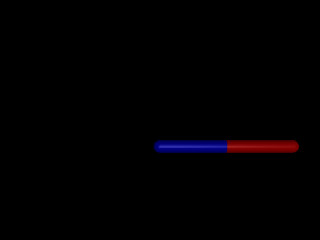

In [42]:
model = mujoco.MjModel.from_xml_string(arm)
data = mujoco.MjData(model)
height = 240
width = 320

with mujoco.Renderer(model, height, width) as renderer:
  mujoco.mj_forward(model, data)
  renderer.update_scene(data, camera="fixed")

  media.show_image(renderer.render())

In [43]:
# setup
n_seconds = 6
framerate = 30  # Hz
n_frames = int(n_seconds * framerate)
frames = []
height = 240
width = 320

# set initial state
mujoco.mj_resetData(model, data)
data.joint('joint1').qvel = 1
data.joint('joint2').qvel = -10

# simulate and record frames
frame = 0
sim_time = 0
render_time = 0
n_steps = 0
with mujoco.Renderer(model, height, width) as renderer:
  for i in range(n_frames):
    while data.time * framerate < i:
      tic = time.time()
      mujoco.mj_step(model, data)
      sim_time += time.time() - tic
      n_steps += 1
    tic = time.time()
    renderer.update_scene(data, "fixed")
    frame = renderer.render()
    render_time += time.time() - tic
    frames.append(frame)

# print timing and play video
step_time = 1e6*sim_time/n_steps
step_fps = n_steps/sim_time
print(f'simulation: {step_time:5.3g} μs/step  ({step_fps:5.0f}Hz)')
frame_time = 1e6*render_time/n_frames
frame_fps = n_frames/render_time
print(f'rendering:  {frame_time:5.3g} μs/frame ({frame_fps:5.0f}Hz)')
print('\n')

# show video
media.show_video(frames, fps=framerate)

simulation:  1.17 μs/step  (851475Hz)
rendering:    640 μs/frame ( 1561Hz)




In [44]:
def forward_kinematics(q, l1=1.0, l2=1.0):
    theta1, theta2 = q
    x = l1 * np.cos(theta1) + l2 * np.cos(theta1 + theta2)
    y = l1 * np.sin(theta1) + l2 * np.sin(theta1 + theta2)
    return np.array([x, y])

def jacobian(q, l1=1.0, l2=1.0):
    theta1, theta2 = q
    J = np.array([
        [-l1*np.sin(theta1)-l2*np.sin(theta1+theta2), -l2*np.sin(theta1+theta2)],
        [ l1*np.cos(theta1)+l2*np.cos(theta1+theta2),  l2*np.cos(theta1+theta2)]
    ])
    return J

def pd_control(q, qd, x_target, Kp=200.0, Kd=20.0):
    x_ee = forward_kinematics(q)
    error = x_target - x_ee
    J = jacobian(q)
    torque = J.T @ (Kp * error) - Kd * qd
    return torque

# Target end-effector position
x_target = np.array([1.5, -1])  # reachable
# set initial state
mujoco.mj_resetData(model, data)
data.joint('joint1').qvel = 0
data.joint('joint2').qvel = 0

height = 240
width = 320
n_seconds = 20
framerate = 30
n_frames = int(n_seconds * framerate)
frames = []

with mujoco.Renderer(model, height, width) as renderer:
    for i in range(n_frames):
        # read joint positions/velocities
        q = data.qpos[:2]
        qd = data.qvel[:2]

        # compute PD torque
        torque = 20*pd_control(q, qd, x_target)
        data.ctrl[:2] = torque

        # step simulation
        mujoco.mj_step(model, data)

        # render frame
        renderer.update_scene(data, camera="fixed")
        frame = renderer.render()
        frames.append(frame)

# show video
media.show_video(frames, fps=framerate)


### solution 2. no change of variable

In [41]:
# --- Load model and data ---
model = mujoco.MjModel.from_xml_string(arm)
data = mujoco.MjData(model)

# --- PD controller parameters ---
Kp = 1.0
Kd = 0.2

# --- Link lengths ---
l1, l2 = 0.5, 0.5

# --- Target end-effector position ---
target = np.array([0.5, -0.5])

# --- Forward kinematics ---
def forward_kinematics(q, l1=0.5, l2=0.5):
    """
    Compute end-effector position from joint angles.
    q: [theta1, theta2]
    """
    theta1, theta2 = q
    x = l1 * np.cos(theta1) + l2 * np.cos(theta1 + theta2)
    y = l1 * np.sin(theta1) + l2 * np.sin(theta1 + theta2)
    return np.array([x, y])

# --- Inverse kinematics ---
def inverse_kinematics(target, l1=0.5, l2=0.5, elbow_up=True):
    x, y = target
    # Distance squared from base to target
    D = (x**2 + y**2 - l1**2 - l2**2) / (2 * l1 * l2)
    # Clip to avoid numerical errors
    D = np.clip(D, -1.0, 1.0)
    
    # theta2
    if elbow_up:
        theta2 = np.arctan2(np.sqrt(1 - D**2), D)   # elbow-up
    else:
        theta2 = np.arctan2(-np.sqrt(1 - D**2), D)  # elbow-down

    # theta1
    theta1 = np.arctan2(y, x) - np.arctan2(l2 * np.sin(theta2), l1 + l2 * np.cos(theta2))
    return np.array([theta1, theta2])

q_target = inverse_kinematics(target, l1, l2)

# --- Simulation settings ---
n_seconds = 15
framerate = 60
n_frames = int(n_seconds * framerate)
height, width = 480, 640
frames = []
with mujoco.Renderer(model, height, width) as renderer:
    for i in range(n_frames):
        while data.time * framerate < i:
            # --- Get current joint states ---
            q = np.array([data.joint('joint1').qpos.item(), data.joint('joint2').qpos.item()])
            qd = np.array([data.joint('joint1').qvel.item(), data.joint('joint2').qvel.item()])

            # --- PD control ---
            torque = (-Kp * (q - q_target) - Kd * qd)*0.1
            data.ctrl[0] = float(torque[0])
            data.ctrl[1] = float(torque[1])

            # ---  Step simulation ---
            mujoco.mj_step(model, data)

            # --- print end-effector position ---
            ee_pos = forward_kinematics(q, l1, l2)
            
        # --- Render frame ---
        renderer.update_scene(data, "fixed")
        frame = renderer.render()
        frames.append(frame)

print('apply forward kinematics to q_target', ee_pos)
print("Target joint angles:", q_target)          # From inverse kinematics
print("Target end-effector position:", target)

media.show_video(frames, fps=framerate)

apply forward kinematics to q_target [ 0.50024113 -0.49969882]
Target joint angles: [-1.57079633  1.57079633]
Target end-effector position: [ 0.5 -0.5]
